In [1]:
# Vanilla python + numpy (for speed) = neural network from scratch!
import numpy as np
import itertools

# Stuff for downloading original MNIST dataset: http://yann.lecun.com/exdb/mnist/
import urllib.request
import gzip
from io import BytesIO

In [2]:
def download_and_unzip_bytes(url):
    response = urllib.request.urlopen(url)
    compressed_file = BytesIO(response.read())
    decompressed_file = gzip.GzipFile(fileobj=compressed_file)
    return decompressed_file.read()

In [3]:
def btos(bytes):
    return int.from_bytes(bytes, 'big')

def parse_images(img_bytes):
    io = BytesIO(img_bytes)
    magic = btos(io.read(4))
    assert magic == 2051 # magic

    n_images = btos(io.read(4))
    rows = btos(io.read(4))
    cols = btos(io.read(4))
    img_sz = rows * cols
    
    images = np.empty((n_images, img_sz))
    for i in range(n_images):
        images[i] = np.frombuffer(io.read(img_sz), dtype=np.uint8)
    return images

def parse_labels(label_bytes):
    io = BytesIO(label_bytes)
    magic = btos(io.read(4))
    assert magic == 2049 # magic

    n_labels = btos(io.read(4))
    return np.frombuffer(io.read(n_labels), dtype=np.uint8)


In [4]:
x_train, y_train, x_valid, y_valid = map(download_and_unzip_bytes, [
    'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
    'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
    'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
    'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
])

In [5]:
x_train, x_valid = map(parse_images, [x_train, x_valid])
y_train, y_valid = map(parse_labels, [y_train, y_valid])

In [6]:
from matplotlib.pyplot import imshow

def show_img(img_vec):
    imshow(img_vec.reshape(28, 28))

5


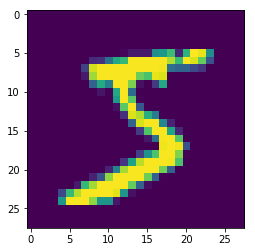

In [8]:
print(y_train[0])
show_img(x_train[0])

7


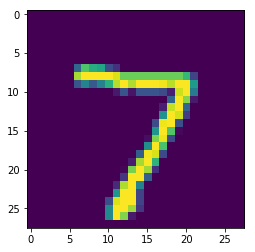

In [11]:
print(y_valid[0])
show_img(x_valid[0])

In [12]:
def normalize(train, valid):
    mn = np.mean(train)
    std = np.std(train)
    return ((train - mn) / std), ((valid - mn) / std)

In [13]:
class Dataset:
    def __init__(self, inputs, labels):
        assert inputs.shape[0] == labels.shape[0]
        self._inputs = inputs
        self._labels = labels

    def __getitem__(self, index):
        return (self._inputs[index], self._labels[index])

    def __len__(self):
        return self._inputs.shape[0]

class DataLoader:
    def __init__(self, dataset: Dataset, batch_size: int = 32):
        self._ds = dataset
        self._batch_size = batch_size

    def __iter__(self):
        for i in range(0, len(self._ds), self._batch_size):
            yield self._ds[i:i + self._batch_size]

In [14]:
train_norm, valid_norm = normalize(x_train, x_valid)
train = Dataset(train_norm, y_train)
valid = Dataset(valid_norm, y_valid)

In [15]:
class Parameter():
    def __init__(self, x):
        self.data = x
        self.grad = 0

In [16]:
class Module():
    def __call__(self, x):
        self._inp = x if isinstance(x, Parameter) else Parameter(x)
        self._out = Parameter(self.forward(x.data))
        return self._out

    def backward(self):
        raise NotImplementedError

    def forward(self, x: np.ndarray):
        raise NotImplementedError

    @property
    def weights(self):
        return []

In [17]:
import pdb

class CrossEntropy(Module):
    def __call__(self, x, targets):
        # pdb.set_trace()
        self._inp = x if isinstance(x, Parameter) else Parameter(x)
        self._softmax = np.exp(self._inp.data) / (np.sum(np.exp(self._inp.data), axis=-1, keepdims=True))
        self._winners = self._softmax.argmax(axis=1)
        probs = self._softmax[np.arange(len(self._winners)), self._winners]

        self._incorrect_ind = (self._winners != targets)
        self._out = probs
        self._out[self._incorrect_ind] = 1 - self._out[self._incorrect_ind]
        self._out = -np.log(self._out)
        return self._winners

    def backward(self):
        # 2 cases - if target OK, just return softmax and -1 in target row
        # if target wrong, return softmax in target and softmax - softmax without target (so it is negative)
        # First case: correct matches
        self._inp.grad = self._softmax
        correct_ind = np.logical_not(self._incorrect_ind)
        self._inp.grad[correct_ind, self._winners[correct_ind]] -= 1 # Negative loss for good labels

        exps_notarget = np.exp(self._inp.data)
        exps_notarget[np.arange(len(self._winners)), self._winners] = 0
        self._softmax1 = exps_notarget / np.sum(exps_notarget, axis=-1, keepdims=True)

        self._softmax1[correct_ind] = 0 # Do not subtract from correct ones
        self._inp.grad -= self._softmax1

class ReLU(Module):
    def forward(self, x):
        return np.maximum(x, 0)

    def backward(self):
        self._inp.grad = self._out.grad * (self._inp.data > 0)

In [18]:
test_inputs = np.array([
  [2, 1],
  [3, 7]             
])

ce = CrossEntropy()
out = ce(test_inputs, np.array([1, 0]))

In [19]:
out

array([0, 1])

In [20]:
ce.backward()
ce._inp.grad

array([[ 0.73105858, -0.73105858],
       [-0.98201379,  0.98201379]])

In [21]:
def print_stats(data: np.ndarray):
    print("Mean:", data.mean(axis=1), "Std:", data.std(axis=1), sep='\n')

In [22]:
class Trainable(Parameter):
    def __init__(self, x):
        super().__init__(x)

class Linear(Module):
    def __init__(self, n_in, n_out):
        self._n_in = n_in
        self._n_out = n_out
        self._w = Trainable(self._initialized_weights(n_in, n_out))
        self._b = Trainable(np.zeros(n_out))

    @staticmethod
    def _initialized_weights(n, m):
        # TODO: kaiming (or some better) init
        return np.random.normal(size=(n, m)) / (2*np.sqrt(m))

    def forward(self, x):
        return x @ self._w.data + self._b.data

    def backward(self):
        # self._inp.grad = (np.expand_dims(self._w, 1) * self._out.grad[np.newaxis,]).sum(axis=-1)
        self._inp.grad = self._out.grad @ self._w.data.T
        self._w.grad = (np.expand_dims(self._inp.data.T, 2) * np.expand_dims(self._out.grad, 0)).sum(axis=1)
        self._b.grad = self._out.grad.sum(axis=0)

    @property
    def weights(self):
        return [self._w, self._b]

In [23]:
vec = train[0:10][0]
lin = Linear(784, 50)
relu = ReLU()
out = lin(vec)
out = relu(out)

In [24]:
print_stats(out.data)

Mean:
[0.54019632 0.55717634 0.60519668 0.67980953 0.63125516 0.70740749
 0.60219954 0.64161567 0.36145155 0.57281204]
Std:
[0.80741711 0.88506085 0.82587999 1.0903679  0.93931869 1.12945576
 0.9051617  0.93908866 0.60617728 0.84258491]


In [25]:
import pdb

class Network(Module):
    def __init__(self, input_dim = 784, n_out_classes = 10):
        self._input_dim = input_dim
        self._n_out_classes = n_out_classes
        self._layers = [
                   Linear(input_dim, 50),
                   ReLU(),
                   Linear(50, n_out_classes)
        ]

        self._loss_function = CrossEntropy()

    def __call__(self, x, targets):
        # pdb.set_trace()
        for layer in self._layers:
            x = layer(x)
        return self._loss_function(x, targets)

    def backward(self):
        self._loss_function.backward()
        for layer in self._layers[::-1]:
            layer.backward()

    @property
    def weights(self):
        return list(itertools.chain(*(layer.weights for layer in self._layers)))


In [26]:
def accuracy(preds, ground_truth):
    return np.mean(preds == ground_truth)

In [27]:
def optimize(param: Trainable, lr=0.002):
    param.data -= lr * param.grad

In [28]:
small_ds = Dataset(train_norm, y_train)
small_valid = Dataset(valid_norm, y_valid)

dl = DataLoader(small_ds)

In [29]:
class Learner():
    def __init__(self, model: Module, dl: DataLoader, valid_set: Dataset):
        self._model = model
        self._dl = dl
        self._valid_set = valid_set
    
    def fit(self, epochs=1, lr=0.002):
        for epoch in range(epochs):
            for batch_x, batch_y in self._dl:
                preds = self._model(batch_x, batch_y)
                self._model.backward()

                for weight in self._model.weights:
                    optimize(weight, lr)

            valid_preds = self._model(*self._valid_set[:])
            print(f"Epoch: {epoch}, Accuracy: {accuracy(valid_preds, self._valid_set[:][1])}")

In [30]:
learn = Learner(Network(), dl, small_valid)

In [31]:
%time learn.fit(epochs=3)

Epoch: 0, Accuracy: 0.9346
Epoch: 1, Accuracy: 0.9497
Epoch: 2, Accuracy: 0.9569
CPU times: user 3min 27s, sys: 3min 16s, total: 6min 44s
Wall time: 34.6 s
